In [ ]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=3541557 sha256=77f3cbc28c932bf0618160bc974a6d79b680b1ce5b82fb3b5006696b5062bafb
  Stored in directory: /root/.cache/pip/wheels/dc/52/e3/6c6b60b126b4d5c4370cb5ac071b82950f91649d62d72f7f56
Successfully built hdbscan


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import hdbscan
from sklearn.metrics import adjusted_rand_score as ari
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift, AgglomerativeClustering

# Dataset 

In [ ]:
url = 'https://github.com/HSE-LAMBDA/ML-IDS/raw/main/course_3/topic_5.1/toy_galaxies_pelican.csv'
data = pd.read_csv(url)

The dataset has coordinates of toy galaxies in 3D-space (x,y,z) and true clusters' label:

In [ ]:
data.head(3)

,x,y,z,label
0,-35.283431,-21.779673,-113.964124,1.0
1,-35.603636,-18.430420,-113.298009,1.0
2,-34.202934,-22.362906,-106.979709,1.0


Let us look at the data:

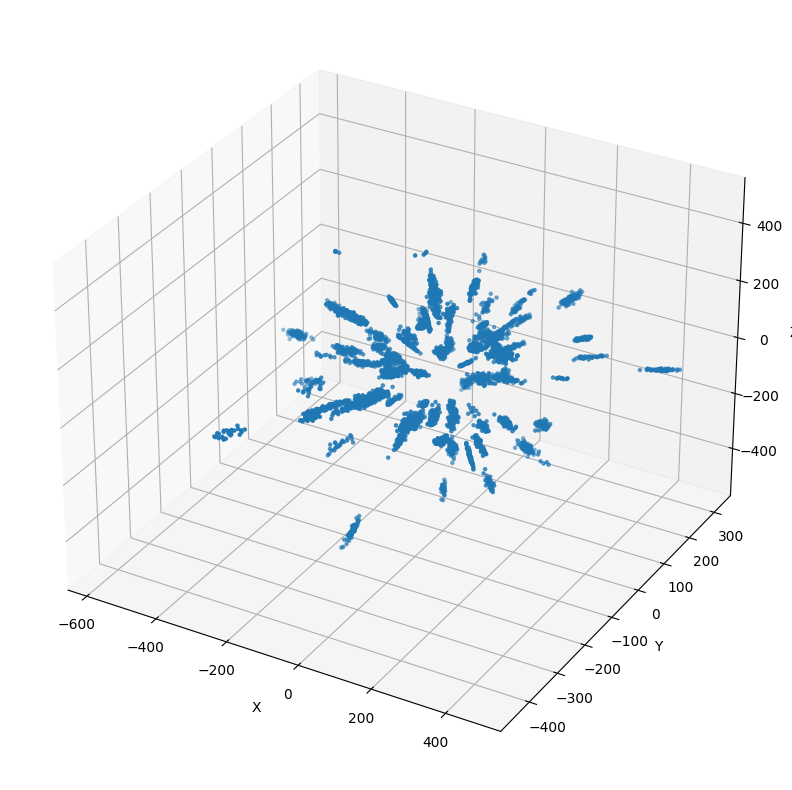

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
Axes3D.scatter(ax, data.x,data.y,data.z, marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show();

In [ ]:
# function that make a plot and print ARI

def plot_galaxies(data,cluster):
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,data.x, data.y, data.z, marker='.', c=cluster.labels_);
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show();

    ARI = round(ari(data.label,cluster.labels_),4)


    print('ARI = {}'.format(ARI))

# Clustering 

The purpose of this task is data clustering. As we have already discussed, before starting to solve the problem, we need to decide what distance metric we will use inside the algorithm and how we will then evaluate the quality of our clustering.

Since we have labeled data, to compare the results we will use the previously encountered Adjusted Rand Index (ARI). Now we need to choose a metric for measuring the distances between objects, which any algorithm uses in its work.

First, let us try a new method for us - Mean-shift clustering. We will use the one from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html) that uses [RBF](https://en.wikipedia.org/wiki/Radial_basis_function) (Radial Basis Function) kernel. We will make few steps of the grid search:

In [ ]:
for i in range (5,40,10):
    cluster = MeanShift(bandwidth=i, n_jobs=-1)
    cluster.fit(data[['x','y','z']].to_numpy())
    print('i={}, ari={}'.format(i,round(ari(data.label,cluster.labels_),4)))

i=5, ari=0.1876
i=15, ari=0.8536
i=25, ari=0.8857
i=35, ari=0.8172


During the grid search the maximum ARI was reached on the bandwidth = 0.8857. 

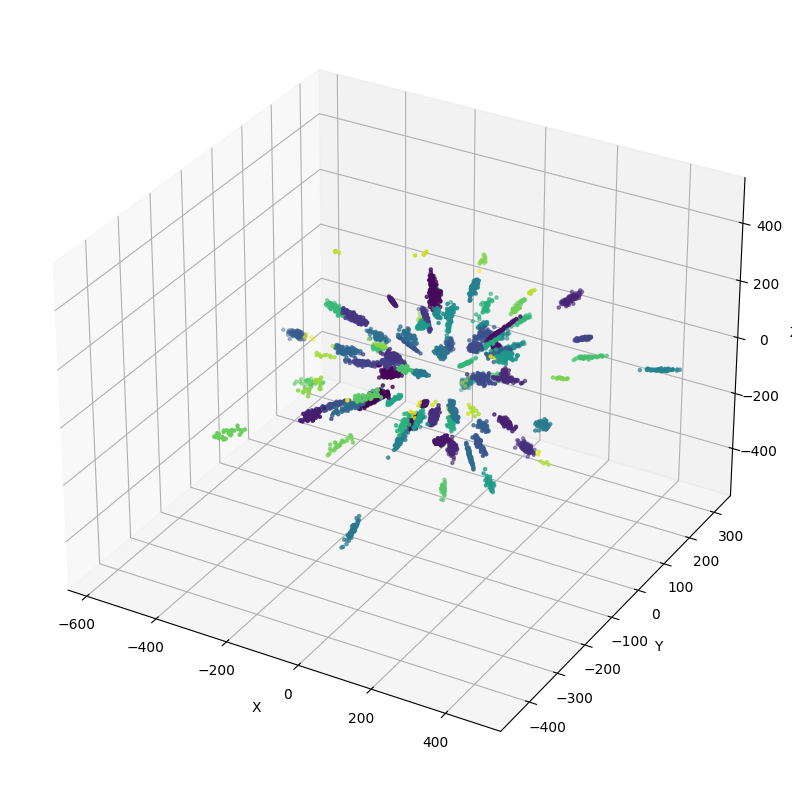

ARI = 0.8857


In [ ]:
cluster = MeanShift(bandwidth=25, n_jobs=-1)
cluster.fit(data[['x','y','z']].to_numpy())

plot_galaxies(data,cluster)

### Using different distance metric

We can see that our data has a certain structure, namely, the clusters of galaxies are elongated along radii directed to the center. This may lead us to the idea that in order to determine clusters, it is sufficient to know only the direction, but not the remotness. Therefore, we will use the cosine distance as the initial metric.

Now let us try to use it in an advanced clustering algorithm - *HDBSCAN* with the following set of parameters:

In [ ]:
cluster = hdbscan.HDBSCAN(metric="cosine",
                          min_cluster_size=9,
                          algorithm="generic",
                          alpha=0.8,
                          cluster_selection_method='eom')

cluster.fit(data[['x','y','z']].to_numpy())

round(ari(data.label,cluster.labels_),4)

0.8729

So, not bad. About $87\%$ of data we clustered well, but it shows ARI worse than MeanShift. So, does it mean that HDBSCAN works worse?

Let us compare the perfomance of the HDBSCAN with 'cosine' and 'euclidean' distances:

In [ ]:
cluster = hdbscan.HDBSCAN(metric="euclidean",
                          min_cluster_size=9,
                          algorithm="generic",
                          alpha=0.8,
                          cluster_selection_method='eom')

cluster.fit(data[['x','y','z']].to_numpy())

round(ari(data.label,cluster.labels_),4)

0.8682

So, you may make sure that for the same set of hyperparameters, except metric, algorithm with the 'cosine' distance works better than with 'euclidean' one. 

Let us visualize the result and print the value of ARI.

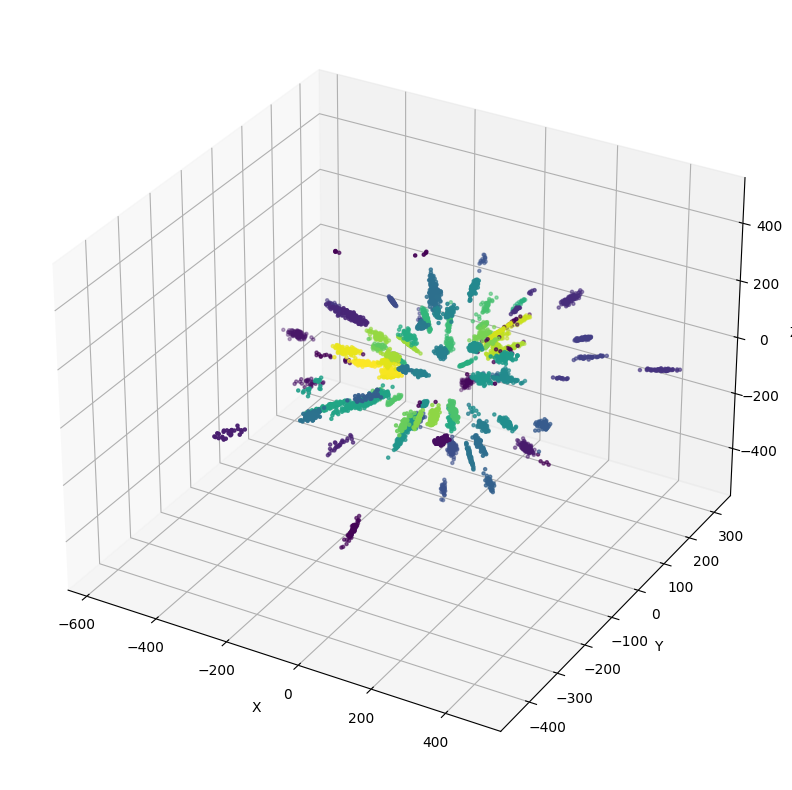

ARI = 0.8682


In [ ]:
plot_galaxies(data,cluster)

### Tasks:

1. **By using any clustering algorithms from *sklearn* with 'cosine' distance try to increase the ARI (0.8857) (+3 score points):**

     (+1) if   0.8729 < ARI $\leq$ 0.88 
     
     (+2) if   0.88 < ARI $\leq$ 0.888 
     
     (+3) if   0.888 < ARI 
     
     
2. **By using any clustering algorithms  with any metric of distance try to obtain the ARI greater than 0.9100 (+3 score points):**

     (+1) if   0.9  < ARI $\leq$ 0.905 
     
     (+2) if   0.905 < ARI $\leq$ 0.91 
     
     (+3) if   0.91 < ARI 

Think, why one distance was better than other?

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


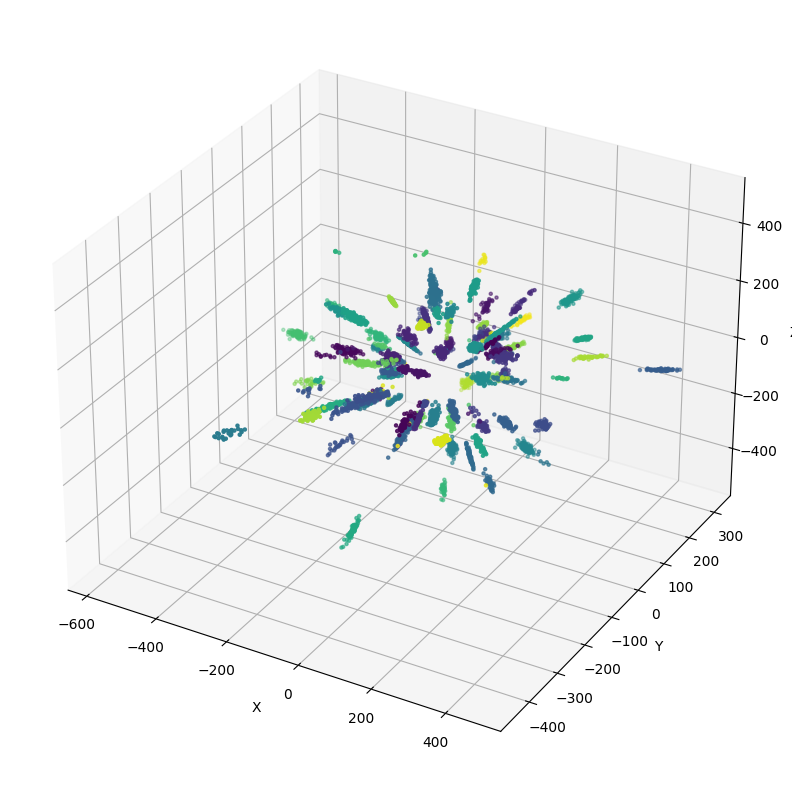

ARI = 0.8889


In [ ]:
#воспроизводим, меняя тип расстояния
# первая задача
cluster = AgglomerativeClustering(n_clusters=125, affinity='cosine',  linkage='average')
cluster.fit(data[['x','y','z']].to_numpy())
plot_galaxies(data,cluster)

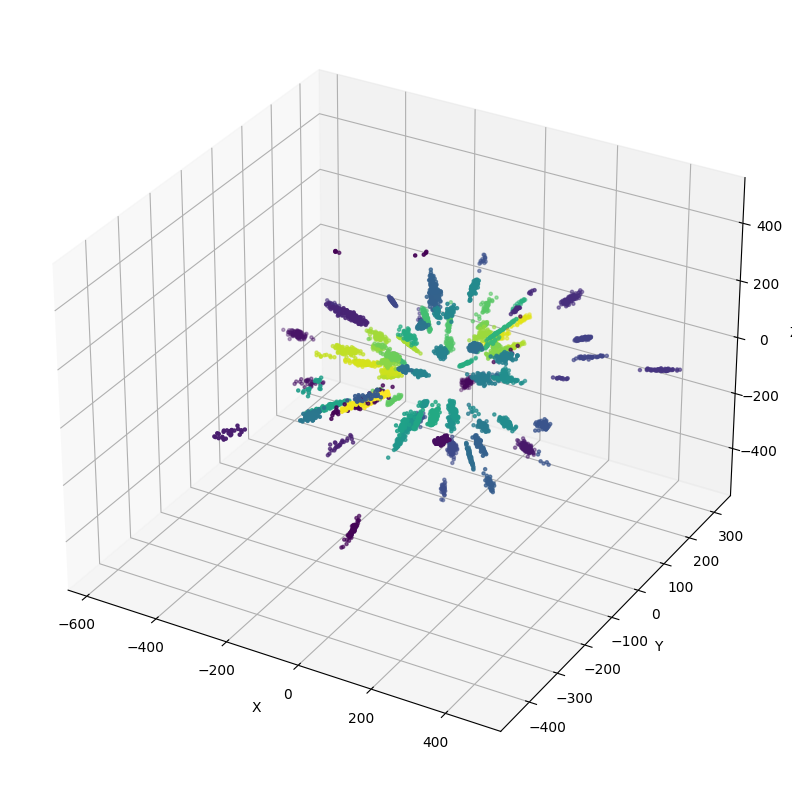

ARI = 0.911


In [ ]:
#аналогично для второй - например, евклидову метрику
cluster = hdbscan.HDBSCAN(metric="euclidean",
                          min_cluster_size=10,
                          algorithm="generic",
                          alpha=0.1,
                          cluster_selection_method='eom')
cluster.fit(data[['x','y','z']].to_numpy())
plot_galaxies(data,cluster)

In [ ]:
# зависит от метркии и ее характера гасить ошибки